In [1]:
%cd Anticipating-Accidents/

/home/dg595/CrashDetection/Azure/Anticipating-Accidents


In [2]:
%%writefile score.py
import json
import numpy as np
import os
import tensorflow as tf

from azureml.core.model import Model
from utils import FeatureExtractor
from accident import build_model

def init():
    global X, feat, sess, soft_pred, all_alphas, keep
    
    feat = FeatureExtractor(device='cpu')
    
    tf.reset_default_graph()
    X,keep,y,optimizer,loss,lstm_variables,soft_pred,all_alphas = build_model(batch_size=1)
    
    model_root = Model.get_model_path('crash-detection')
    saver = tf.train.import_meta_graph(os.path.join(model_root, 'model/final_model.meta'))
    
    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)
    saver.restore(sess, os.path.join(model_root, 'model/final_model'))

def run(raw_data):
    try:
        data = np.array(json.loads(raw_data)['data'])
        data = np.uint8(data)

        # get features
        features, boxes = feat.extract_features([data])
        features, boxes = features[0], np.int64(boxes[0])

        features = np.expand_dims(np.repeat(features[np.newaxis,...], 100, axis=0), axis=0)

        # make prediction
        [out, weights] = sess.run([soft_pred, all_alphas], feed_dict={X: features, keep: [0.0]})
        y_hat = out #np.argmax(out, axis=1)
        print("y_hat: ", y_hat)
        return y_hat.tolist(), weights.tolist(), boxes.tolist()
    except Exception as e:
    result = str(e)
    # return error message back to the client
    return json.dumps({"error": result})

Overwriting score.py


In [3]:
# from azureml.core.runconfig import CondaDependencies

# cd = CondaDependencies.create()
# cd.add_conda_package('opencv')
# cd.add_pip_package('torch')
# cd.add_pip_package('torchvision')
# cd.add_tensorflow_conda_package()

# cd.save_to_file(base_directory='./', conda_file_path='myenv.yml')

# print(cd.serialize_to_string())

In [4]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores=2, 
                                               memory_gb=2, 
                                               tags={'name':'CrashDetecton', 'framework': 'TensorFlow DNN'},
                                               description='Tensorflow DNN for Accident Detection')

In [5]:
from azureml.core.image import ContainerImage

imgconfig = ContainerImage.image_configuration(execution_script="score.py", 
                                               runtime="python", 
#                                                conda_file="myenv.yml",
                                               dependencies=['utils.py', 'predictor.py', 'accident.py'])

In [6]:
# use an image available in a private Container Registry
imgconfig.base_image = "crashdetector.azurecr.io/maskrcnn"
imgconfig.base_image_registry.address = "crashdetector.azurecr.io"
imgconfig.base_image_registry.username = "crashdetector"
imgconfig.base_image_registry.password = "Ycy+YnxoyvYruvORaPl1WqwxWbW7Buu6"

In [7]:
from azureml.core.webservice import Webservice
from azureml.core import Workspace
from azureml.core.model import Model

ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep='\n')

model = Model(ws, 'crash-detection')

# model.download(target_dir='/Users/Amrut/CrashDetection/CarCrashModel/', exist_ok=True)

# # verify the downloaded model file
# file_path = os.path.join('/Users/Amrut/CrashDetection/CarCrashModel/outputs', "final_model.meta")

# os.stat(file_path)

# Register the image from the image configuration
image = ContainerImage.create(name = "crash-detection",
                              models = [model], #this is the model object
                              image_config = imgconfig,
                              workspace = ws
                              )

image.wait_for_creation(show_output=True)

Found the config file in: /home/dg595/CrashDetection/Azure/Anticipating-Accidents/.azureml/config.json
Workspace name: AccidentDetection
Azure region: eastus
Subscription id: e298a653-a33f-4b32-9ec2-2adfbd3b649d
Resource group: CCGroup7Resources
Creating image
Running................................................................................................................
SucceededImage creation operation finished for image crash-detection:21, operation "Succeeded"


In [8]:
service = Webservice.deploy_from_image(workspace=ws,
                                       name='crash-detection',
                                       deployment_config=aciconfig,
                                       image=image)

service.wait_for_deployment(show_output=True)

print(service.get_logs())
print(service.scoring_uri)

Creating service
Running................................................................................................................................................................................................................................................
TimedOutACI service creation operation finished, operation "TimedOut"
Service creation polling reached terminal state, current service state: Unhealthy
{
  "code": "AciHealthEndpointNotUp",
  "message": "Health endpoint is not up"
}
2019-04-30T01:22:59,826407953+00:00 - iot-server/run 
2019-04-30T01:22:59,827032554+00:00 - gunicorn/run 
2019-04-30T01:22:59,827189655+00:00 - nginx/run 
2019-04-30T01:22:59,826542753+00:00 - rsyslog/run 
EdgeHubConnectionString and IOTEDGE_IOTHUBHOSTNAME are not set. Exiting...
2019-04-30T01:23:00,709155708+00:00 - iot-server/finish 1 0
2019-04-30T01:23:00,717273126+00:00 - Exit code 1 is normal. Not restarting iot-server.
Starting gunicorn 19.6.0
Listening at: http://127.0.0.1:9090 (11)
Using w

In [9]:
print(service.scoring_uri)

http://52.191.232.105:80/score


In [25]:
print(service.get_logs())

backbone.body.layer3.20.conv3.weight             loaded from layer3.20.conv3.weight       of shape (1024, 256, 1, 1)
backbone.body.layer3.21.bn1.bias                 loaded from layer3.21.bn1.bias           of shape (256,)
backbone.body.layer3.21.bn1.weight               loaded from layer3.21.bn1.weight         of shape (256,)
backbone.body.layer3.21.bn2.bias                 loaded from layer3.21.bn2.bias           of shape (256,)
backbone.body.layer3.21.bn2.weight               loaded from layer3.21.bn2.weight         of shape (256,)
backbone.body.layer3.21.bn3.bias                 loaded from layer3.21.bn3.bias           of shape (1024,)
backbone.body.layer3.21.bn3.weight               loaded from layer3.21.bn3.weight         of shape (1024,)
backbone.body.layer3.21.conv1.weight             loaded from layer3.21.conv1.weight       of shape (256, 1024, 1, 1)
backbone.body.layer3.21.conv2.weight             loaded from layer3.21.conv2.weight       of shape (256, 256, 3, 3)
backbone.bod

In [23]:
# service.update(auth_enabled = True)

WebserviceException: Received bad response from Model Management Service:
Response Code: 409
Headers: {'Date': 'Tue, 30 Apr 2019 01:36:12 GMT', 'Content-Type': 'application/json', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive', 'Request-Context': 'appId=cid-v1:2d2e8e63-272e-4b3c-8598-4ee570a0e70d', 'api-supported-versions': '1.0, 2018-03-01-preview, 2018-11-19', 'x-ms-client-request-id': '775e1da0b5af4f44978667bb5ec6b037', 'x-ms-client-session-id': '', 'Strict-Transport-Security': 'max-age=15724800; includeSubDomains; preload'}
Content: b'{"code":"Conflict","statusCode":409,"message":"Conflict","details":[{"code":"ConflictOfOperation","message":"Conflict of operation, another operation on same entity is already running"}]}'

In [ ]:
primary, secondary = service.get_keys()
print(primary)

In [16]:
# TEST DEPLOYMENT #

from PIL import Image
from io import BytesIO

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
import requests
import json
import cv2 

# this makes our figures bigger
pylab.rcParams['figure.figsize'] = 20, 12

def load(url):
    """
    Given an url of an image, downloads the image and
    returns a PIL image
    """
    response = requests.get(url)
    pil_image = Image.open(BytesIO(response.content)).convert("RGB")
    # convert to BGR format
    image = np.array(pil_image)[:, :, [2, 1, 0]]
    return image

def imshow(img):
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")

In [17]:
url = 'https://ncadvertiser.com/wp-content/uploads/sites/82/2018/04/Cop-Car-Crash-close.jpg'

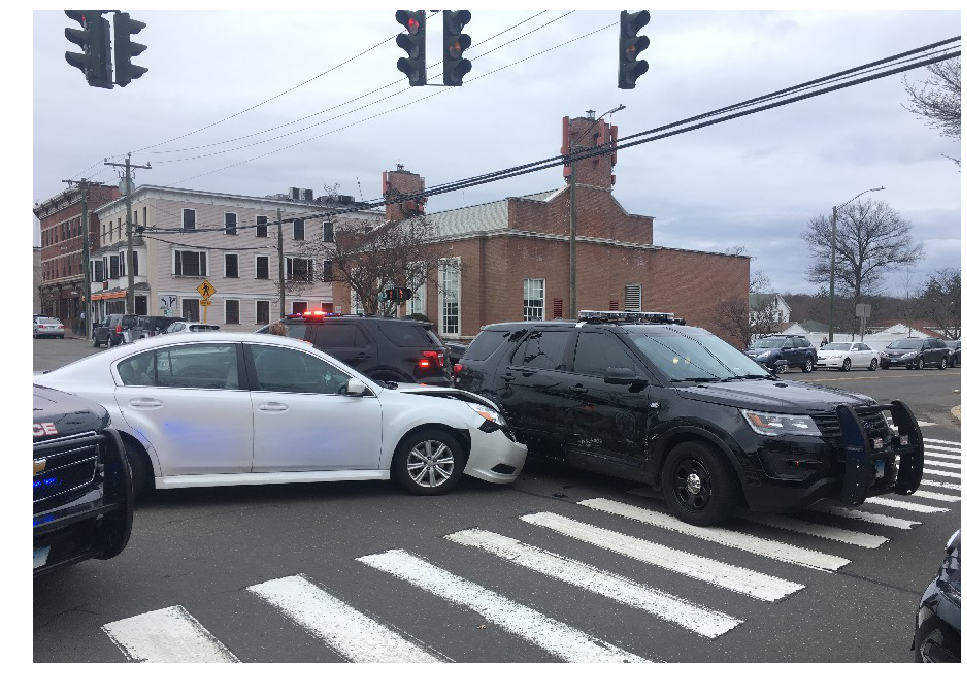

In [18]:
image = load(url)
imshow(image)

In [27]:
test_image = json.dumps({'data': image.tolist()})
test_image = bytes(test_image, encoding='utf8')
print(type(test_image))
result = service.run(test_image)

<class 'bytes'>


WebserviceException: Received bad response from service:
Response Code: 504
Headers: {'X-Ms-Request-Id': 'd93f60bb-8b32-4988-9964-70df430227f2', 'Date': 'Tue, 30 Apr 2019 01:42:36 GMT', 'Content-Length': '109', 'Content-Type': 'text/plain; charset=utf-8'}
Content: b'Post http://localhost:5001/score: net/http: request canceled (Client.Timeout exceeded while awaiting headers)'

In [ ]:
prob, weight, boxes = result
weight, boxes = np.array(weight), np.array(boxes)